In [4]:
import at3d
import numpy as np
import os
import sys
import xarray as xr
from collections import OrderedDict
import pylab as py
path = '/Users/khargenr/AT3D/at3d'

In [5]:
#load the cloud.
cloud_scatterer = at3d.util.load_from_csv(os.path.join(path, './data/synthetic_cloud_fields/jpl_les/rico32x37x26.txt'),
                                           density='lwc',origin=(0.0,0.0))

#load atmosphere
atmosphere = xr.open_dataset(os.path.join(path, './data/ancillary/AFGL_summer_mid_lat.nc'))
#subset the atmosphere
reduced_atmosphere = atmosphere.sel({'z': atmosphere.coords['z'].data[atmosphere.coords['z'].data <= 10.0]})
#merge the atmosphere and cloud z coordinates
#merged_z_coordinate = at3d.grid.combine_z_coordinates([aerosol_scatterer, cloud_scatterer])

#make a merged grid for the rte.
rte_grid = at3d.grid.make_grid(cloud_scatterer.x[1]-cloud_scatterer.x[0],cloud_scatterer.x.size,
                           cloud_scatterer.y[1]-cloud_scatterer.y[0],cloud_scatterer.y.size,
                           cloud_scatterer.z)

In [6]:

# rte_grid = at3d.grid.make_grid(0.1, 10, 0.1, 10, merged_z_coordinate)
#resample the cloud onto the rte_grid
cloud_scatterer_on_rte_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer)

#define any necessary variables for microphysics here.
#We choose a gamma size distribution and therefore need to define a 'veff' variable.
cloud_scatterer_on_rte_grid['veff'] = (cloud_scatterer_on_rte_grid.reff.dims,
                                       np.full_like(cloud_scatterer_on_rte_grid.reff.data, fill_value=0.1))


# Reconstruction MODIS + MISR

In [7]:
#define sensors.
sensor_resolution = 0.02
sensors_dict = at3d.containers.SensorsDict()
sensor_zenith_list =  [75.0,60.0,45.6,26.1]*2 + [0.0]
sensor_azimuth_list = [90]*4 + [-90]*4 +[0.0]
for zenith,azimuth in zip(sensor_zenith_list, sensor_azimuth_list):
    sensors_dict.add_sensor('MISR',
                    at3d.sensor.orthographic_projection(0.66, 
                                                           rte_grid, 
                                                           sensor_resolution, 
                                                           sensor_resolution,
                                                           azimuth, zenith,
                                                           altitude='TOA', stokes=['I'])
                           )
    for wavelength in [1.64, 2.13]:
        sensors_dict.add_sensor('MODIS',
        at3d.sensor.orthographic_projection(wavelength, 
                                            rte_grid, 
                                            sensor_resolution, 
                                            sensor_resolution,
                                            azimuth, zenith,
                                            altitude='TOA', stokes=['I'])
                            )
wavelengths = sensors_dict.get_unique_solvers()
min_stokes = sensors_dict.get_minimum_stokes()

In [8]:
#rayleigh optical properties if desired.
rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths, atmosphere, rte_grid)

In [9]:
solvers = at3d.containers.SolversDict()
cloud_poly_tables = OrderedDict()

for wavelength in wavelengths:
    mie_mono_table = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
    # print(wavelength)
    # #optical properties from mie calculations.
    # # Cloud
    # water_file = './mie_tables/mie_table_water_SWIR_%d.nc'%(wavelength*1e3)
    # try:
    #     mie_mono_table = xr.load_dataset(water_file)
    # except IOError:
    #     mie_mono_table = at3d.mie.get_mono_table(
    #         'Water', 
    #         (wavelength, wavelength),
    #         minimum_effective_radius=0.1,
    #     )
    #     mie_mono_table.to_netcdf(water_file, mode='w')
    cloud_size_distribution = at3d.size_distribution.get_size_distribution_grid(
        mie_mono_table.radius.data,
        size_distribution_function=at3d.size_distribution.gamma,
        particle_density=1.0,
        reff={'coord_min':.1,'coord_max':30.0,'npoints':30,'spacing':'linear','units':'micron'},
        veff={'coord_min':0.09,'coord_max':0.11,'npoints':2,'spacing':'linear','units':'unitless'},
    )
    poly_table = at3d.mie.get_poly_table(cloud_size_distribution, mie_mono_table)
    cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
    cloud_poly_tables[wavelength] = poly_table

    # Define solvers
    config = at3d.configuration.get_config()
    config['num_mu_bins'] = 8
    config['num_phi_bins'] = 16
    config['split_accuracy'] = 0.03
    config['spherical_harmonics_accuracy'] = 0 #.001
    config['solution_accuracy'] = 1e-4
    solvers.add_solver(
        wavelength, 
        at3d.solver.RTE(
            numerical_params=config,
            medium={
                'cloud': cloud_optical_scatterer,
                'rayleigh': rayleigh_scatterer_list[wavelength]
            },
            source=at3d.source.solar(wavelength, np.cos(np.deg2rad(60.0)), 0.0, solarflux=1.0),
            surface=at3d.surface.ocean_unpolarized(10.0, 0.0, delx=10.0, dely=10.0),
            num_stokes=min_stokes[wavelength],
            name=None
        )
    )

In [10]:
# get total OD
for wvl in wavelengths:
    sensor_od = sensors_dict['MISR']['sensor_list'][-1]
    solvers[wvl].optical_path(sensor_od)
    print('cloud OD @ %.3f nm ='%wvl, sensor_od.optical_path.data.mean())
    # get Rayleigh OD

cloud OD @ 0.660 nm = 3.301307
cloud OD @ 1.640 nm = 3.3963447
cloud OD @ 2.130 nm = 3.4415367


In [11]:
#very important for the retrieval. the unknowns are visible extinction
#and reff not LWC and Reff. Much more orthogonal.
scaling_factor = cloud_poly_tables[0.66].extinction[:].copy(deep=True).data
#print(scaling_factor)
for wavelength in cloud_poly_tables:
    cloud_poly_tables[wavelength]['extinction'][:] /= scaling_factor

In [12]:
sensors_dict.get_measurements(solvers, n_jobs=8)


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 1.640 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 2.130 micron]
     1  -0.607  0.324E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     1  -0.555  0.272E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     1  -0.652  0.355E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     2  -1.110  0.370E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     2  -1.012  0.321E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     2  -1.309  0.397E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     3  -1.482  0.393E+00    30784    16.04  0.251   [Radiance 1.640 micron]
     3  -1.431  0.349E+00    30784    16.04  0.251   [Radiance 2.130 micron]
     3  -1.637  0.413E+00    30784    16.04  0.251   [Radiance 0.660 micron]
     4  -1.718  0.313E+00    30824    16.11  0.252   [Radiance 1.640 micron]
     4  

In [13]:
def retrieve(uncertainty = 6e9, scale = 1.5e2):
    Sensordict = sensors_dict
    uncertainty = at3d.uncertainties.NullUncertainty('L2', uncertainty)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
                #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
    Sensordict.add_uncertainty_model('MISR', uncertainty)
    # uncertainty = at3d.uncertainties.RadiometricNoiseUncertainty(0, .001)
    # Sensordict.add_uncertainty_model('MISR', uncertainty)
    # Sensordict.add_noise('MISR')
    # Sensordict.add_uncertainty_model('MODIS', uncertainty)
    # Sensordict.add_noise('MODIS')
    forward_sensors = Sensordict.make_forward_sensors() # make a perfect copy of the sensor with the same subpixel rays.

    scale_reff = scale
    #scale_aerosol_density = 1e4

    wavelengths = forward_sensors.get_unique_solvers()

    mask = solvers[0.66].medium['cloud'].extinction.data > 0.0

    ext_profile = np.sum(solvers[0.66].medium['cloud'].extinction.data, axis=(0,1))
    CBH = rte_grid.z.data[np.where(ext_profile>0)[0][0]]
    CTH = rte_grid.z.data[np.where(ext_profile>0)[0][-1]]
    print(CBH, CTH)
    initial_cloud = xr.Dataset(
        data_vars={
            'density':(['x','y','z'], np.ones((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))),
            'reff': (['x','y','z'], np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+10.0),
            'veff':(['x','y','z'] ,np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))+0.1)
        },
        coords=rte_grid.coords
    )

    #resample the cloud onto the rte_grid
    initial_cloud_on_grid = at3d.grid.resample_onto_grid(rte_grid, cloud_scatterer_on_rte_grid.copy(deep=True))
    reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))

    def state_to_grid_density_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[mask] = state[1:]
        return state_on_grid

    def state_to_grid_reff_cloud(state):
        state_on_grid = np.zeros((rte_grid.x.size, rte_grid.y.size, rte_grid.z.size))
        state_on_grid[:,:,:] = state[0]*(rte_grid.z.data-0.44)**(1.0/3)/scale_reff #+state[1]/scale3
        state_on_grid[np.where(state_on_grid < 4.1)] = 4.1
        state_on_grid[np.where(np.isnan(state_on_grid))] = 4.1
        return state_on_grid

    solvers_reconstruct = at3d.containers.SolversDict()
    rayleigh_scatterer_list = at3d.rayleigh.to_grid(wavelengths,atmosphere,rte_grid)

    def set_state_fn(state):

        #update microphysics
        #aerosol_scatterer_on_rte_grid = initial_aerosol_on_grid.copy(deep=True)
        cloud_scatterer_on_rte_grid = initial_cloud_on_grid.copy(deep=True)

        cloud_scatterer_on_rte_grid['density'][:] = state_to_grid_density_cloud(state)
        cloud_scatterer_on_rte_grid['reff'][:] = state_to_grid_reff_cloud(state)
        #update optical properties
        for wavelength in wavelengths:
            poly_table = cloud_poly_tables[wavelength] #tables are used here.
            cloud_optical_scatterer = at3d.medium.table_to_grid(cloud_scatterer_on_rte_grid, poly_table)
            #cloud_optical_scatterer['extinction'][:] = state_to_grid_ext_cloud(state)
            
            #aerosol_poly_table = aerosol_poly_tables[wavelength]
            #aerosol_optical_scatterer = at3d.medium.table_to_grid(aerosol_scatterer_on_rte_grid, aerosol_poly_table)
            #aerosol_optical_scatterer['extinction'][:] = state_to_grid_ext_aerosol(state)      

    #         config = at3d.configuration.get_config('./default_config.json')
    #         config['num_mu_bins'] = 2
    #         config['num_phi_bins'] = 4
    #         config['split_accuracy'] = 0.1
    #         config['spherical_harmonics_accuracy'] = 0.001
    #         config['solution_accuracy'] = 1e-5
            solvers_reconstruct.add_solver(wavelength, at3d.solver.RTE(#numerical_params=config,
                                    numerical_params=solvers[wavelength].numerical_params,#config,
                                                    medium={'cloud': cloud_optical_scatterer,
                                                        'rayleigh': rayleigh_scatterer_list[wavelength]
                                                        },
                                                    source=solvers[wavelength].source,
                                                    surface=solvers[wavelength].surface,
                                                    num_stokes=solvers[wavelength]._nstokes,
                                                    name=None
                                                    )
                                    )

    # unknown_scatterers = at3d.containers.UnknownScatterers()
    # unknown_scatterers.add_unknown('cloud', ['density','reff'], cloud_poly_tables)
    # unknown_scatterers.create_derivative_tables()

    mie_mono_tables = OrderedDict()
    for wavelength in wavelengths:
        mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
            'Water',(wavelength,wavelength),
            max_integration_radius=65.0,
            minimum_effective_radius=0.1,
            relative_dir='../mie_tables',
            verbose=False
        )

    optical_property_generator = at3d.medium.OpticalPropertyGenerator(
        'cloud', 
        mie_mono_tables,
        at3d.size_distribution.gamma,
        density_normalization='geometric_extinction',
        reff=np.linspace(.1,30.0,30),
        veff=np.linspace(0.03,0.2,9),
    )

    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, cloud_optical_scatterer
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
            reff=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridProfile(mask=mask)),
            density=(at3d.transforms.CoordinateTransformScaling(0, 1), at3d.transforms.StateToGridMask(mask=mask))
        #reff=(at3d.transforms.CoordinateTransform(), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data))
        )
    )

    def project_gradient_to_state(state, gradient):
        cloud_gradient = gradient.gradient.sel(variable_name='density',
                                            scatterer_name='cloud').data[mask]

        reff_gradient = gradient.gradient.sel(variable_name='reff',
                                            scatterer_name='cloud').where(mask, np.nan)
        
        reff_gradient1 = np.nansum(reff_gradient, axis=(0,1))*(rte_grid.z.data - 0.44)**(1.0/3)
        #reff_gradient2 = np.nansum(reff_gradient,axis=(0,1))

        full_grad = np.append(np.nansum(reff_gradient1)/scale_reff, cloud_gradient)
        
        #print some things here because I'm lazy.
        print('reff', state[0]/scale_reff , full_grad[0])
        print('cloud density avg.', np.mean(state[1:]), np.mean(full_grad[1:]))
        print('reff profile retrieve', state_to_grid_reff_cloud(state).mean(axis=(0,1)))
        print('reff profile true', reff_profile_true)
        return full_grad

    min_bound = np.zeros(1+np.sum(mask))+1e-5
    min_bound[0] = 1e-4*scale_reff

    max_bound = np.zeros(1+np.sum(mask))+199
    max_bound[0] = 29.9*scale_reff

    obj_fun = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        Sensordict, 
        solvers_reconstruct,
        forward_sensors,
        unknown_scatterers,
        set_state_fn,
        project_gradient_to_state,
        #exact_single_scatter=False,
        parallel_solve_kwargs={'n_jobs': 4, 'mpi_comm':None,
                                    'verbose':False, 'maxiter':100, 'init_solution':True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':False},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bound,
        max_bounds=max_bound
    )

    # initial guess
    x0_reff = 10
    x0_ext_cloud = 10
    x0 = np.append(np.array([x0_reff*scale_reff]), x0_ext_cloud*np.ones(np.sum(mask)))
    print(x0)
    print(state_to_grid_reff_cloud(x0).mean(axis=(0,1)))
    optimizer = at3d.optimize.Optimizer
    optimizer = at3d.optimize.Optimizer
    optimizer.options

    #define optimizer (no prior function)
    optimizer = at3d.optimize.Optimizer(obj_fun)#, prior_fn=prior_func)
    optimizer._options['maxls'] = 8
    optimizer._options['maxiter'] = 20 #maxiter to 1 to debug the saving of result.
    #optimize for the specified initial condition.
    result = optimizer.minimize(x0)
    return solvers_reconstruct[.66].medium['cloud'].reff.data.max(), np.nanmean(solvers_reconstruct[.66].medium['cloud'].density.data[mask])

In [14]:
uncertainties = np.exp(np.arange(0, .6, .2))*5.0e9
print(uncertainties)
scales = np.exp(np.arange(0, .6, .2))*5.5
print(scales)

[5.00000000e+09 6.10701379e+09 7.45912349e+09]
[5.5        6.71771517 8.20503584]


1 out of 9
------uncertainty 5000000000.0 scale 5.5 -------
0.56 1.4


/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/gradient.py:110: UserWarning: No uncertainty model supplied for instrument 'MODIS'. Using at3d.uncertainties.NullUncertainty which isequivalent to unweighted least squares.
  warnings.warn(


[55. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1416.4109319448526
cloud density avg. 10.0 -6.817824620516641
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

         


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 74.18711571383439
cloud density avg. 19.61943882736491 -1.1120697985438655
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 3.4144845696410218 -259.0976678933593
cloud density avg. 19.62381685566562 0.01432737668537978
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.7

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '542'. Max cell optical depth: '2.505110502243042'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '572'. Max cell optical depth: '2.695288896560669'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "
/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '676'. Max cell optical depth: '2.7784504890441895'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


Further cell splitting requires larger array allocations:  Ncells=  198574  Npnts=  153917
reff 29.9 21190149079.957092
cloud density avg. 66.61933203905654 nan
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 6.018891483395762 -27.912961593634193
cloud density avg. 19.705209580249893 0.13705784856370137
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.11686386 4.28171096 4.43475716 4.57791164
 4.7126327  4.84006241 4.9611138  5.07652969 5

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[67.1771517 10.        10.        ... 10.        10.        10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1159.6591889790952
cloud density avg. 10.0 -6.817824620516641
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 61.58844750598205
cloud density avg. 19.527372226319915 -1.1158061638850634
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 3.2782212334117364 -212.95819693679857
cloud density avg. 19.550065965347724 0.03361911605225639
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 1

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[82.05035837 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 949.4486411066563
cloud density avg. 10.0 -6.817824620516641
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    n

/Users/khargenr/miniconda3/envs/at3d/lib/python3.10/site-packages/at3d/solver.py:2337: UserWarning: Number of SHDOM grid cells with optical depth greater than 2: '5'. Max cell optical depth: '2.040097713470459'
  warnings.warn("Number of SHDOM grid cells with optical depth greater than 2: '{}'. "


reff 3.882644546310398 -843.7892999022745
cloud density avg. 23.539471778117722 0.5194487877734094
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 0.16943508131322121 -145.8514695469745
cloud density avg. 19.415133673842906 0.01377177930032435
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 0.10355778793329075 -129.9576511253895
cloud density avg. 19.34196240950822 -0.0035695832003049812
reff profile retrieve [4.1 4.

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[55. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1730.0082188232552
cloud density avg. 10.0 -8.327309795829223
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

         


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 100.87848978923826
cloud density avg. 19.097775462406215 -1.4529442102830592
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 2.121129614304835 -224.08371575968548
cloud density avg. 19.39061953445302 0.3033424291655119
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 29.9 101.57960479162911
cloud density avg. 19.070431062245117 -1.4657739869104736
reff profile retrieve [ 4.1        10.22565616 12.88351945 14.7479482  16.23221735 17.48562607
 18.58125039 19.56097653 20.45131232 21.27022196 22.03050836 22.74165572
 23.41090849 24.04394004 24.64528609 25.21863669 25.76703889 26.29304144
 26.79880038 27.28615776 27.75670123 28.21181    28.65269075 29.0804059
 29.49589641 29.9       ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 6.098418007770608 37.97529586284364
cloud density avg. 19.33816713950589 0.13385012350295677
reff profile retrieve [4.1        4.1        4.1        4.1        4.1        4.1
 4.1        4.1        4.17125924 4.33828444 4.49335281 4.63839875
 4.77489986 4.90401327 5.0266641  5.14360495 5.25545732 5.36274105
 5.46589588 5.56529752 5.66126979 5.75409398 5.84401623 

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[67.1771517 10.        10.        ... 10.        10.        10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1416.4109318282617
cloud density avg. 10.0 -8.327309795829223
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698   

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[82.05035837 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1159.6591888836388
cloud density avg. 10.0 -8.327309795829223
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


reff 16.70792406275434 136.54152148493827
cloud density avg. 19.51874753294131 -1.1330283559220475
reff profile retrieve [ 4.1         5.71402965  7.19922624  8.24105681  9.07045668  9.77085327
 10.38308095 10.9305455  11.42805931 11.88566065 12.3105037  12.70788819
 13.08186225 13.43559613 13.77162437 14.09200892 14.39845248 14.69237926
 14.97499404 15.24732615 15.51026275 15.76457455 16.01093582 16.24994025
 16.48211362 16.70792406]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
reff 2.2584510094215275 -118.93788955504408
cloud density avg. 19.639156469250015 0.12193217437288496
reff profile retrieve [4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1
 4.1 4.1 4.1 4.1 4.1 4.1 4.1 4.1]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 1


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[55. 10. 10. ... 10. 10. 10.]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 2113.0368099680823
cloud density avg. 10.0 -10.170999152357899
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698    nan]
RUNNING THE L-BFGS-B CODE

        

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[67.1771517 10.        10.        ... 10.        10.        10.       ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1730.0082187066644
cloud density avg. 10.0 -10.170999152357899
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698  

/var/folders/tq/1q0g78nx5zg1y2kq5s69xgz80000gq/T/ipykernel_22006/956757203.py:35: RuntimeWarning: Mean of empty slice
  reff_profile_true = np.nanmean(cloud_scatterer.reff.data, axis=(0,1))


[82.05035837 10.         10.         ... 10.         10.
 10.        ]
[ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff 10.0 1416.4109317328052
cloud density avg. 10.0 -10.170999152357899
reff profile retrieve [ 4.1         4.1         4.30886938  4.93242415  5.42883523  5.84803548
  6.21446501  6.54213262  6.83990379  7.11378661  7.368063    7.60590492
  7.82973528  8.04145152  8.2425706   8.43432665  8.61773876  8.79365934
  8.96280949  9.12580527  9.28317767  9.43538796  9.58283971  9.72588826
  9.8648483  10.        ]
reff profile true [   nan    nan    nan 11.685 12.521 13.314 14.001 14.607 15.106 15.532
 15.904 16.321 16.756 17.022 17.261 17.425 17.593 17.794 17.99  18.176
 18.325 18.425 18.506 18.573 18.698   

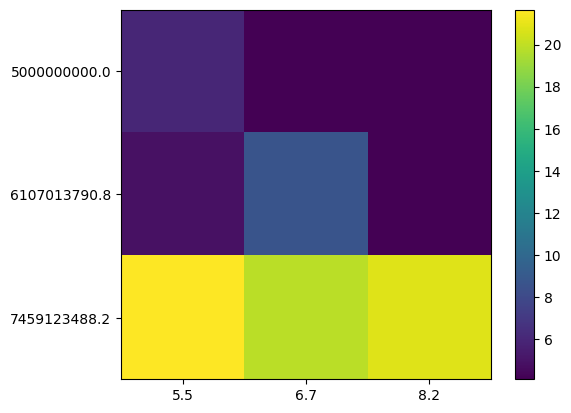

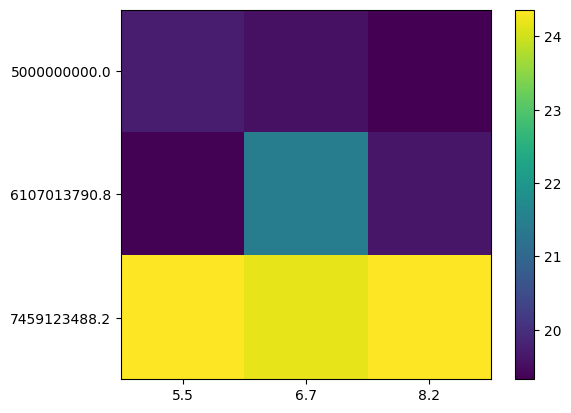

CPU times: user 1d 11h 24min 27s, sys: 41min 1s, total: 1d 12h 5min 28s
Wall time: 12h 18min


In [15]:
%%time
reff_2d = []
density_2d = []
count = 0
for i in uncertainties:
    reff_1d = []
    density_1d = []
    for j in scales:
        count += 1
        print(str(count) + " out of " + str(len(uncertainties)*len(scales)))
        print("------uncertainty", i, "scale", j, "-------")
        reff, density = retrieve(i, j)
        reff_1d.append(reff)
        density_1d.append(density)
    reff_2d.append(reff_1d)
    density_2d.append(density_1d)

rounded_uncertainties = np.round(uncertainties, 1)
rounded_scales = np.round(scales, 1)
img = py.imshow(reff_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()

img = py.imshow(density_2d)
py.xticks(np.arange(len(scales)), labels=rounded_scales)
py.yticks(np.arange(len(uncertainties)), labels=rounded_uncertainties)
py.colorbar(img)
py.show()


In [16]:
reff_2d[1][0]
uncertainties[4]
# scales[2]

IndexError: index 4 is out of bounds for axis 0 with size 3